In [1]:
import pickle

import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, roc_auc_score, average_precision_score, confusion_matrix, classification_report

import seaborn as sns

In [2]:
x_train, y_train = None, None
with open('data/train.pickle', 'rb') as file:
    x_train, y_train = pickle.load(file)

x_test, y_test = None, None
with open('data/test.pickle', 'rb') as file:
    x_test, y_test = pickle.load(file)

In [3]:
cat_map = {'Fully Paid' : 0, 'Charged Off' : 1}

In [4]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [5]:
x_train = x_train.values
x_test = x_test.values
x_val = x_val.values

In [6]:
y_train = y_train.apply(lambda x: cat_map[x])
y_test = y_test.apply(lambda x: cat_map[x])
y_val = y_val.apply(lambda x : cat_map[x])

In [7]:
num_feat = x_train.shape[1]

In [8]:
print('Majority Classification Accuracy:',len(y_train[y_train == 0])/(len(y_train[y_train == 0])+len(y_train[y_train == 1])))

Majority Classification Accuracy: 0.8053629374951712


In [9]:
def get_model():
    model = Sequential([
      Dense(128, activation='relu', input_shape = (num_feat,)),
      Dropout(0.4),
      Dense(128, activation='relu'),
      Dropout(0.2),
      Dense(128, activation='relu'),
      Dense(1, activation = 'sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [10]:
import matplotlib.pyplot as plt
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    ax = sns.lineplot(loss, label = 'Loss')
    ax = sns.lineplot(val_loss, label = 'Val_Loss', ax = ax)
    ax = sns.lineplot(acc, label = 'Acc', ax = ax, linestyle='dashed')
    ax = sns.lineplot(val_acc, label = 'Val_Acc', ax = ax, linestyle='dashed')
    plt.show()

2023-04-21 18:03:22.176628: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


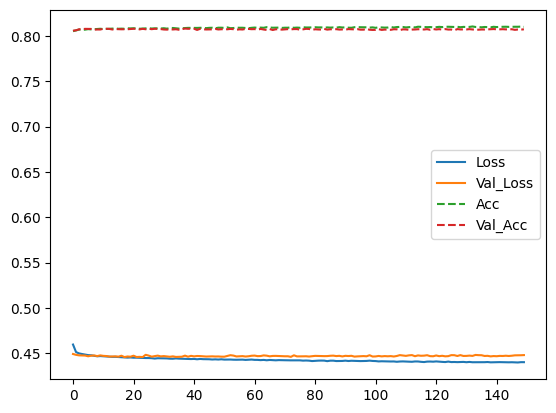

In [11]:
epochs = 150
batch_size = 128

model = get_model()
history = model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                    epochs=epochs, batch_size=batch_size, verbose = 0)
plot_history(history)

In [12]:
def get_test_metric(model):
    loss, acc = model.evaluate(x_test, y_test, verbose = 0)
    y_pred = (model.predict(x_test, verbose = 0) > 0.5).astype("int32")
    y_logit = model.predict(x_test, verbose = 0)
    auc = roc_auc_score(y_test, y_logit)
    aps = average_precision_score(y_test, y_logit)
    f1 = f1_score(y_test, y_pred)
    print(classification_report(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d')
    plt.show()
    print(f'Test Loss : {loss:>.5f} Acc : {acc : >.5f}')
    print(f"Auc : {auc: >.5f}")
    print(f"Avg Prec Score : {aps:>.5f}")
    print(f"F1 Score : {f1:>.5f}")

              precision    recall  f1-score   support

           0       0.81      0.99      0.89     52217
           1       0.55      0.06      0.11     12565

    accuracy                           0.81     64782
   macro avg       0.68      0.52      0.50     64782
weighted avg       0.76      0.81      0.74     64782



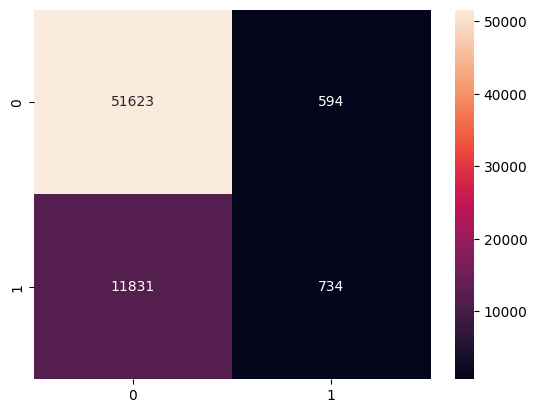

Test Loss : 0.44649 Acc : 0.80820
Auc : 0.71311
Avg Prec Score : 0.37190
F1 Score : 0.10566


In [13]:
get_test_metric(model)

## Random Oversampling

In [14]:
from imblearn.over_sampling import RandomOverSampler

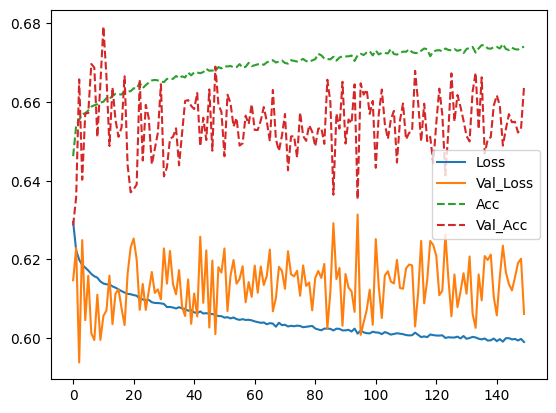

              precision    recall  f1-score   support

           0       0.88      0.67      0.76     52217
           1       0.31      0.63      0.42     12565

    accuracy                           0.66     64782
   macro avg       0.60      0.65      0.59     64782
weighted avg       0.77      0.66      0.69     64782



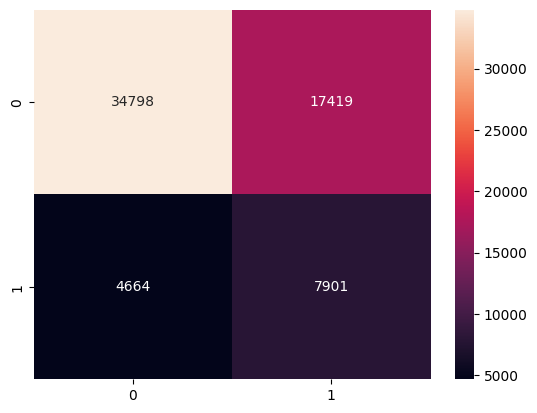

Test Loss : 0.60581 Acc : 0.65912
Auc : 0.70662
Avg Prec Score : 0.37147
F1 Score : 0.41710


In [15]:
ros = RandomOverSampler(random_state=42)
x_over, y_over = ros.fit_resample(x_train, y_train)

model_over = get_model()
history = model_over.fit(x_over, y_over, validation_data = (x_val, y_val), 
                    epochs=epochs, batch_size=batch_size, verbose = 0)
plot_history(history)
get_test_metric(model_over)

## Random Undersampling

In [16]:
from imblearn.under_sampling import RandomUnderSampler

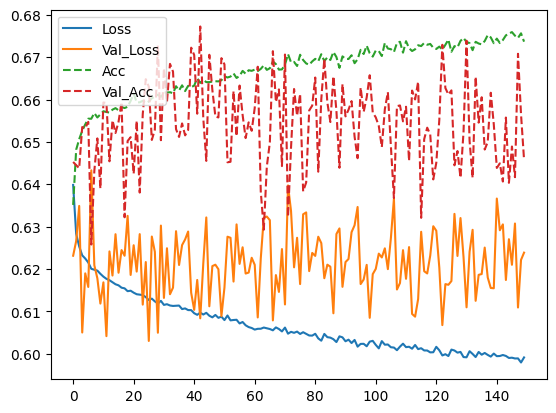

              precision    recall  f1-score   support

           0       0.88      0.64      0.74     52217
           1       0.30      0.65      0.41     12565

    accuracy                           0.64     64782
   macro avg       0.59      0.65      0.58     64782
weighted avg       0.77      0.64      0.68     64782



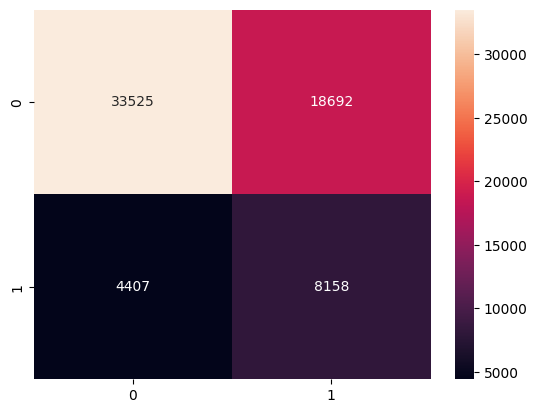

Test Loss : 0.62326 Acc : 0.64343
Auc : 0.70569
Avg Prec Score : 0.35821
F1 Score : 0.41395


In [17]:
rus = RandomUnderSampler(random_state=42, replacement=True)
x_under, y_under = rus.fit_resample(x_train, y_train)

model_under = get_model()
history = model_under.fit(x_under, y_under, validation_data = (x_val, y_val), 
                    epochs=epochs, batch_size=batch_size, verbose = 0)
plot_history(history)
get_test_metric(model_under)

## SMOTE

In [18]:
from imblearn.over_sampling import SMOTE

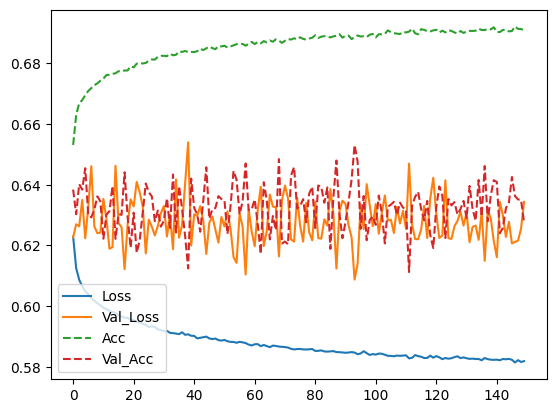

              precision    recall  f1-score   support

           0       0.88      0.63      0.73     52217
           1       0.29      0.64      0.40     12565

    accuracy                           0.63     64782
   macro avg       0.58      0.63      0.57     64782
weighted avg       0.76      0.63      0.67     64782



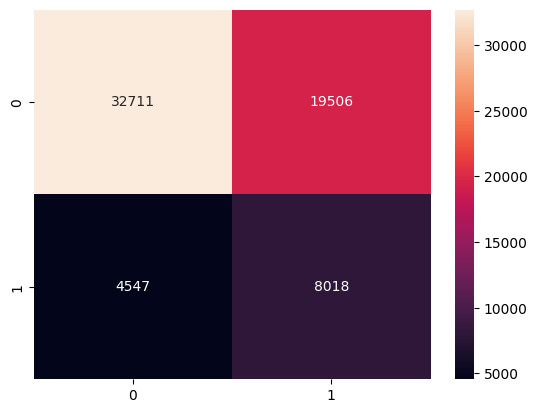

Test Loss : 0.63301 Acc : 0.62871
Auc : 0.68800
Avg Prec Score : 0.34558
F1 Score : 0.40001


In [19]:
sm = SMOTE(random_state=42)
x_sm, y_sm = sm.fit_resample(x_train, y_train)

model_sm = get_model()
history = model_sm.fit(x_sm, y_sm, validation_data = (x_val, y_val), 
                    epochs=epochs, batch_size=batch_size, verbose = 0)
plot_history(history)
get_test_metric(model_sm)